Howdy

In [20]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pylab

In [3]:
def gillespie(initial, event_rates, duration):
    
    time = [0]
    values = [initial]
    
    # Stop when when  
    while time[-1] < duration:
        
        # Get most resent values
        update = values[-1].copy()
        
        # Determine probability/rate
        probabilities = [event_rates[0]*sum(update), # Birth
                       event_rates[1]*update[0]*update[1]/sum(update), # Infection
                       event_rates[2]*update[1], # Recovery
                       event_rates[3]*update[0], # Death S
                       event_rates[4]*update[1], # Death I
                       event_rates[5]*update[2]] # Death R
            
        # Determine the next event
        dt = []
        for rate in probabilities:
            if rate == 0:
                dt.append(np.inf)
            else:
                dt.append(-1/rate*np.log(random.random()))
            
        t = time[-1] + min(dt)
        event = dt.index(min(dt))
         
        # Compute event
        if event == 0:
            # Birth
            update[0] += 1
            
        elif event == 1:
            # Infection
            update[0] -= 1
            update[1] += 1
            
        elif event == 2:
            # Recovery
            update[1] -= 1
            update[2] += 1
            
        elif event == 3:
            # Death susceptible
            update[0] -= 1
            
        elif event == 4:
            # Death infected
            update[1] -= 1
            
        elif event == 5:
            # Death Recovered
            update[2] -= 1
        
        # Make sure population >= 0
        if update[0] < 0:
            update[0] = 0
        elif update[1] < 0:
            update[1] = 0
        elif update[2] < 0:
            update[2] = 0
            
        
        # append the data
        time.append(t)
        values.append(update)
        
    return time, values

In [4]:
def SIR_demography(y, t, N, infection_rate, recover_rate, birth_death_rate):
    '''SIR model with demography'''
    
    dSdt = birth_death_rate - infection_rate*y[0]*y[1] - birth_death_rate*y[0]
    dIdt = infection_rate*y[0]*y[1] - recover_rate*y[1] - birth_death_rate*y[1]
    dRdt = recover_rate*y[1] - birth_death_rate*y[2]
    
    return [dSdt, dIdt, dRdt]

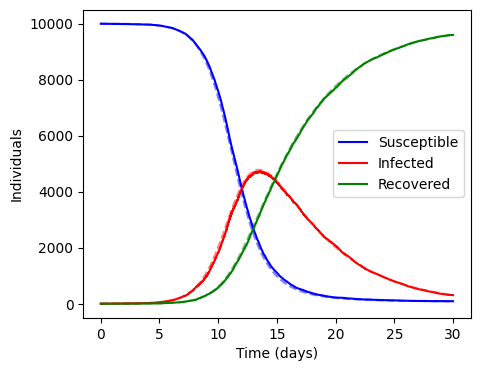

In [5]:
# Define population parameters
N = 10000
I0 = 1

# Define model parameters
infection_rate = 1/5 * 5
recover_rate = 1/5
birth_death_rate = 1/(365*65)

# Duration of simulation
days = 30

# Parameters for gillepsie algorithm
initial = [N-I0, I0, 0]
event_rates = [birth_death_rate, infection_rate, recover_rate, birth_death_rate, birth_death_rate, birth_death_rate]

# Run gillepsie algorithm
time, values = gillespie(initial, event_rates, days)

# Gather values over time for each compartment
susceptible = [event[0] for event in values]
infected = [event[1] for event in values]
recovered = [event[2] for event in values]

# Inital parameters deterministic model
y0 = [(N-I0)/N, I0/N, 0]

# Determine timesteps and resolution
t = np.linspace(0, days, 1001)

# Get deteministic solution
solution = odeint(SIR_demography, y0, t, args=(N, infection_rate, recover_rate, birth_death_rate))

# Plot data
fig = plt.figure(figsize=(5,4))

# Plot deteministic model
plt.plot(t, solution[:,0] * N,'b--', alpha=0.5)
plt.plot(t, solution[:,1] * N,'r--', alpha=0.5)
plt.plot(t, solution[:,2] * N,'g--', alpha=0.5)

# Plot gillepsie model
plt.plot(time, susceptible, 'b-', label=r'Susceptible')
plt.plot(time, infected, 'r-', label=r'Infected')
plt.plot(time, recovered, 'g-', label=r'Recovered')

plt.ylabel('Individuals')
plt.xlabel('Time (days)')
plt.legend(loc='best')
plt.show()

EXTINCTION

NOTE: mu excluded from calculations of R_0 as we look at the infected population after 30 days and mu only has impact after years.

In [10]:
# Define population parameters
N = 10000
I0 = 1

n_simulations = 10

# Define model parameters

# List for all R_0 values
R_0 = np.linspace(1, 5, 5)
recover_rate = 1/5
# Infection rates are calculated from r_0 and recover rate 
infection_rates = R_0 * recover_rate
birth_death_rate = 1/(365*65)

# Duration of simulation
days = 30

# Parameters for gillepsie algorithm
initial = [N-I0, I0, 0]

extiction_rates = []

# Run n_simulations for each infection rate (so each value of R_0)
for inf_rate in infection_rates:
    
    # Determine the rates for each event
    event_rates = [birth_death_rate, inf_rate, recover_rate, birth_death_rate, birth_death_rate, birth_death_rate]
    # 
    extinctions = []
    for j in range(n_simulations):
        
        # Run gillepsie algorithm
        time, values = gillespie(initial, event_rates, days)

        # Check if disease went extinct
        extinct = True if values[-1][1] == 0 else False
        
        extinctions.append(extinct)
    
    extiction_rates.append(np.mean(extinctions))

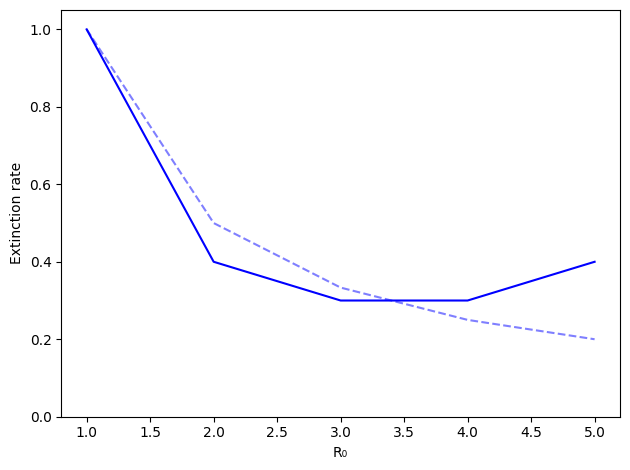

In [37]:
plt.plot(R_0, 1/R_0, 'b--', alpha=0.5)


# Plot results of the extinction experiment
plt.plot(R_0, extiction_rates, 'b-')
plt.xlabel(f'R\u2080')
plt.ylabel('Extinction rate')
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

In [ ]:
# Define population parameters
N = 10000
I0 = 1

n_simulations = 10

# Define model parameters

# List for all R_0 values
R_0 = np.linspace(1, 5, 5)
recover_rate = 1/5
# Infection rates are calculated from r_0 and recover rate 
infection_rates = R_0 * recover_rate
birth_death_rate = 1/(365*65)

# Duration of simulation
days = 30

population_sizes = [100, 1000, 10000, 100000]

data = []
for N in population_sizes:
    
    # Parameters for gillespie algorithm
    initial = [N-I0, I0, 0]

    extiction_rates = []

    # Run n_simulations for each infection rate (so each value of R_0)
    for inf_rate in infection_rates:
        
        # Determine the rates for each event
        event_rates = [birth_death_rate, inf_rate, recover_rate, birth_death_rate, birth_death_rate, birth_death_rate]
        # 
        extinctions = []
        for j in range(n_simulations):
            
            # Run gillespie algorithm
            time, values = gillespie(initial, event_rates, days)

            # Check if disease went extinct
            extinct = True if values[-1][1] == 0 else False
            
            # 
            extinctions.append(extinct)
        
        extiction_rates.append(np.mean(extinctions))
        
    data.append(extiction_rates)

TODO: 
- Pick better collors
- Run 100 simulations per R_0
- Run for 21 values of R_0

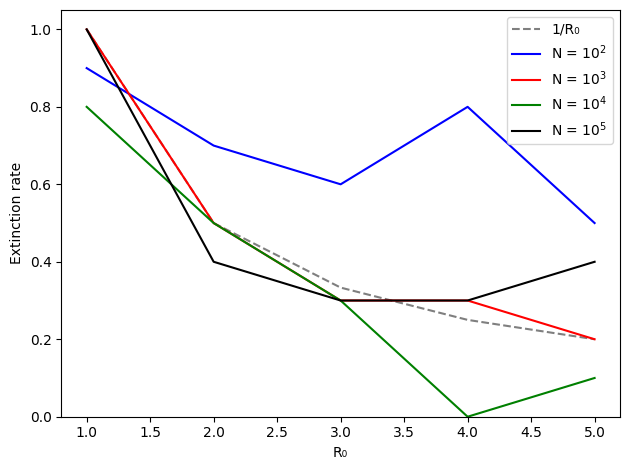

In [ ]:
plt.plot(R_0, 1/R_0, 'k--', alpha=0.5)

colors = ['b', 'r', 'g', 'k']

# Plot results of the extinction experiment
for i, N in enumerate(data):
    plt.plot(R_0, N, colors[i])
    
    
plt.xlabel(f'R\u2080')
plt.ylabel('Extinction rate')
plt.ylim([0, 1.05])
plt.legend(['1/R\u2080', 'N = $10^2$', 'N = $10^3$', 'N = $10^4$', 'N = $10^5$'], loc='upper right')
plt.tight_layout()
plt.show()

NETWORK

In [121]:
# Imports
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.utils import multi_runs
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

In [ ]:
# Network Definition
g = nx.erdos_renyi_graph(1000, 0.1)

# Model Selection
model = ep.SIRModel(g)

# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.001)
config.add_model_parameter('gamma', 0.01)
config.add_model_parameter("fraction_infected", 0.05)
model.set_initial_status(config)


# Simulation multiple execution
trends = multi_runs(model, execution_number=10, iteration_number=200, infection_sets=None, nprocesses=4)# Simulation

# iterations = model.iteration_bunch(200)
# trends = model.build_trends(iterations)

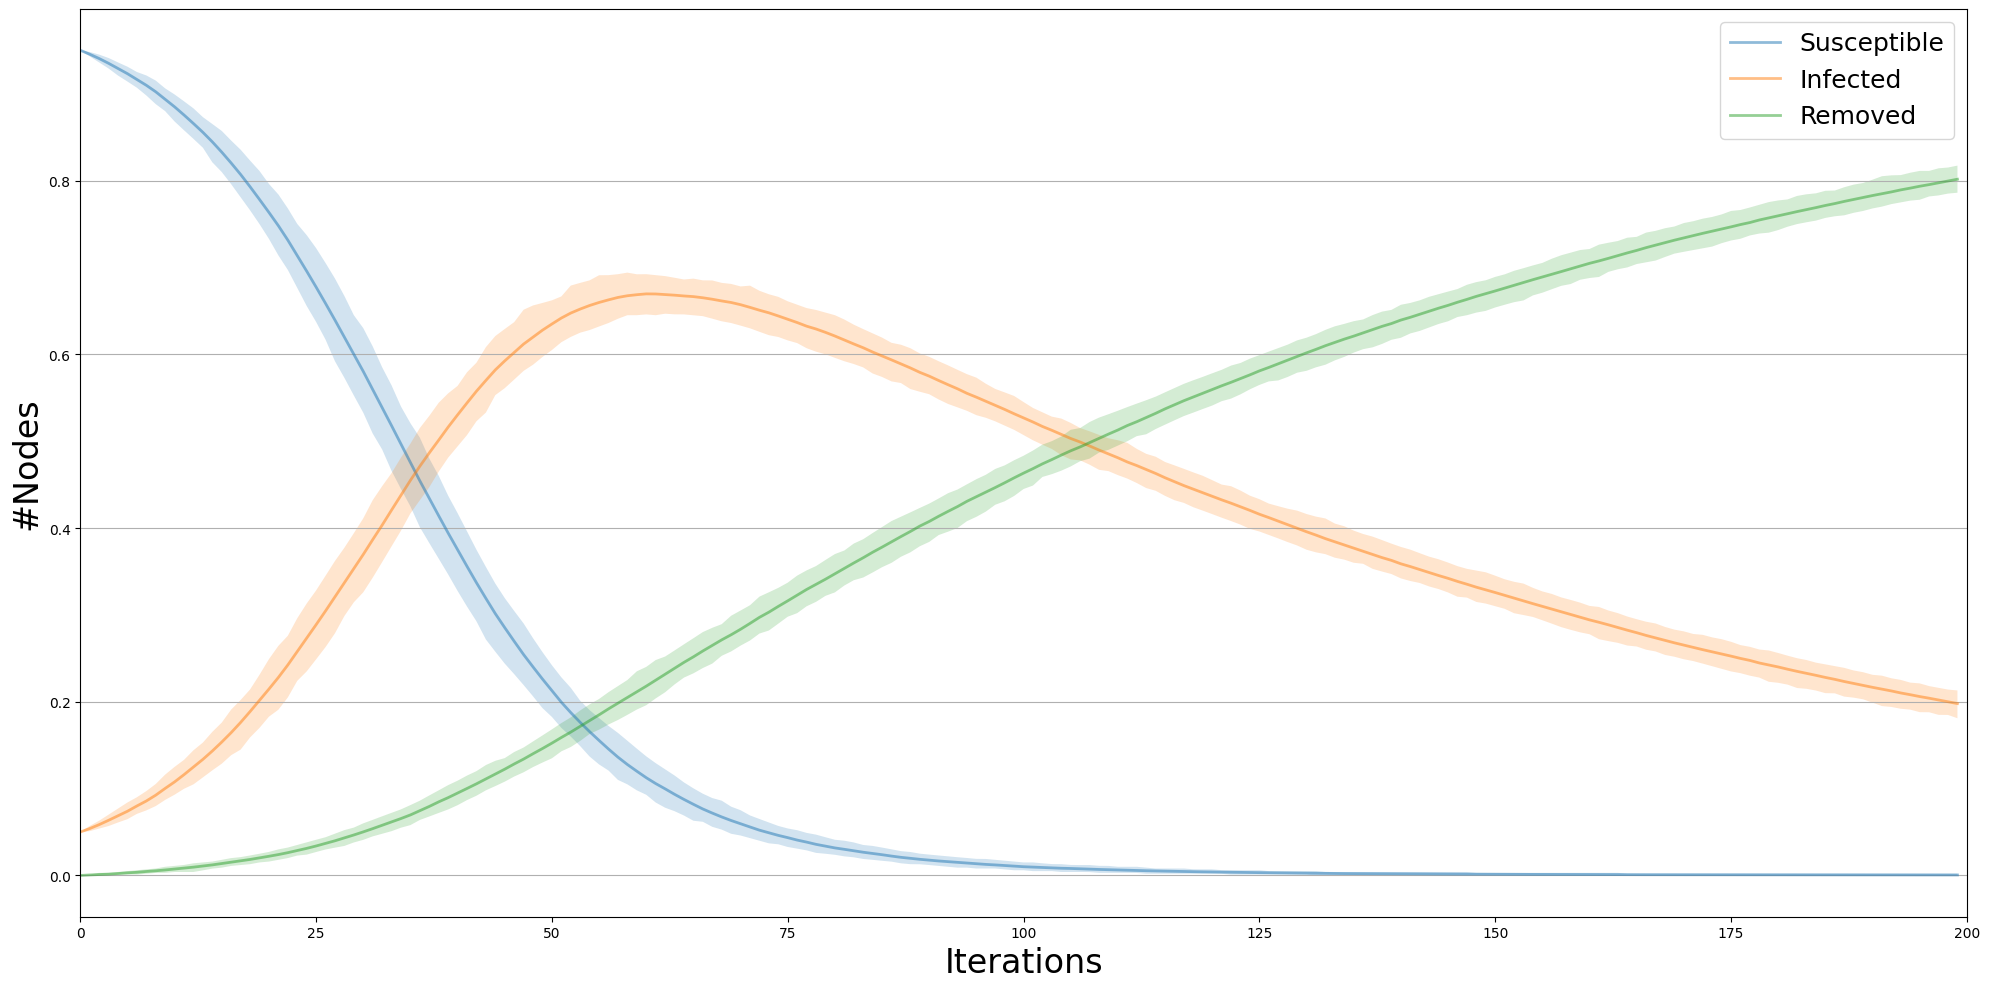

In [126]:
# Plot diffuction trend
viz = DiffusionTrend(model, trends)
viz.plot()

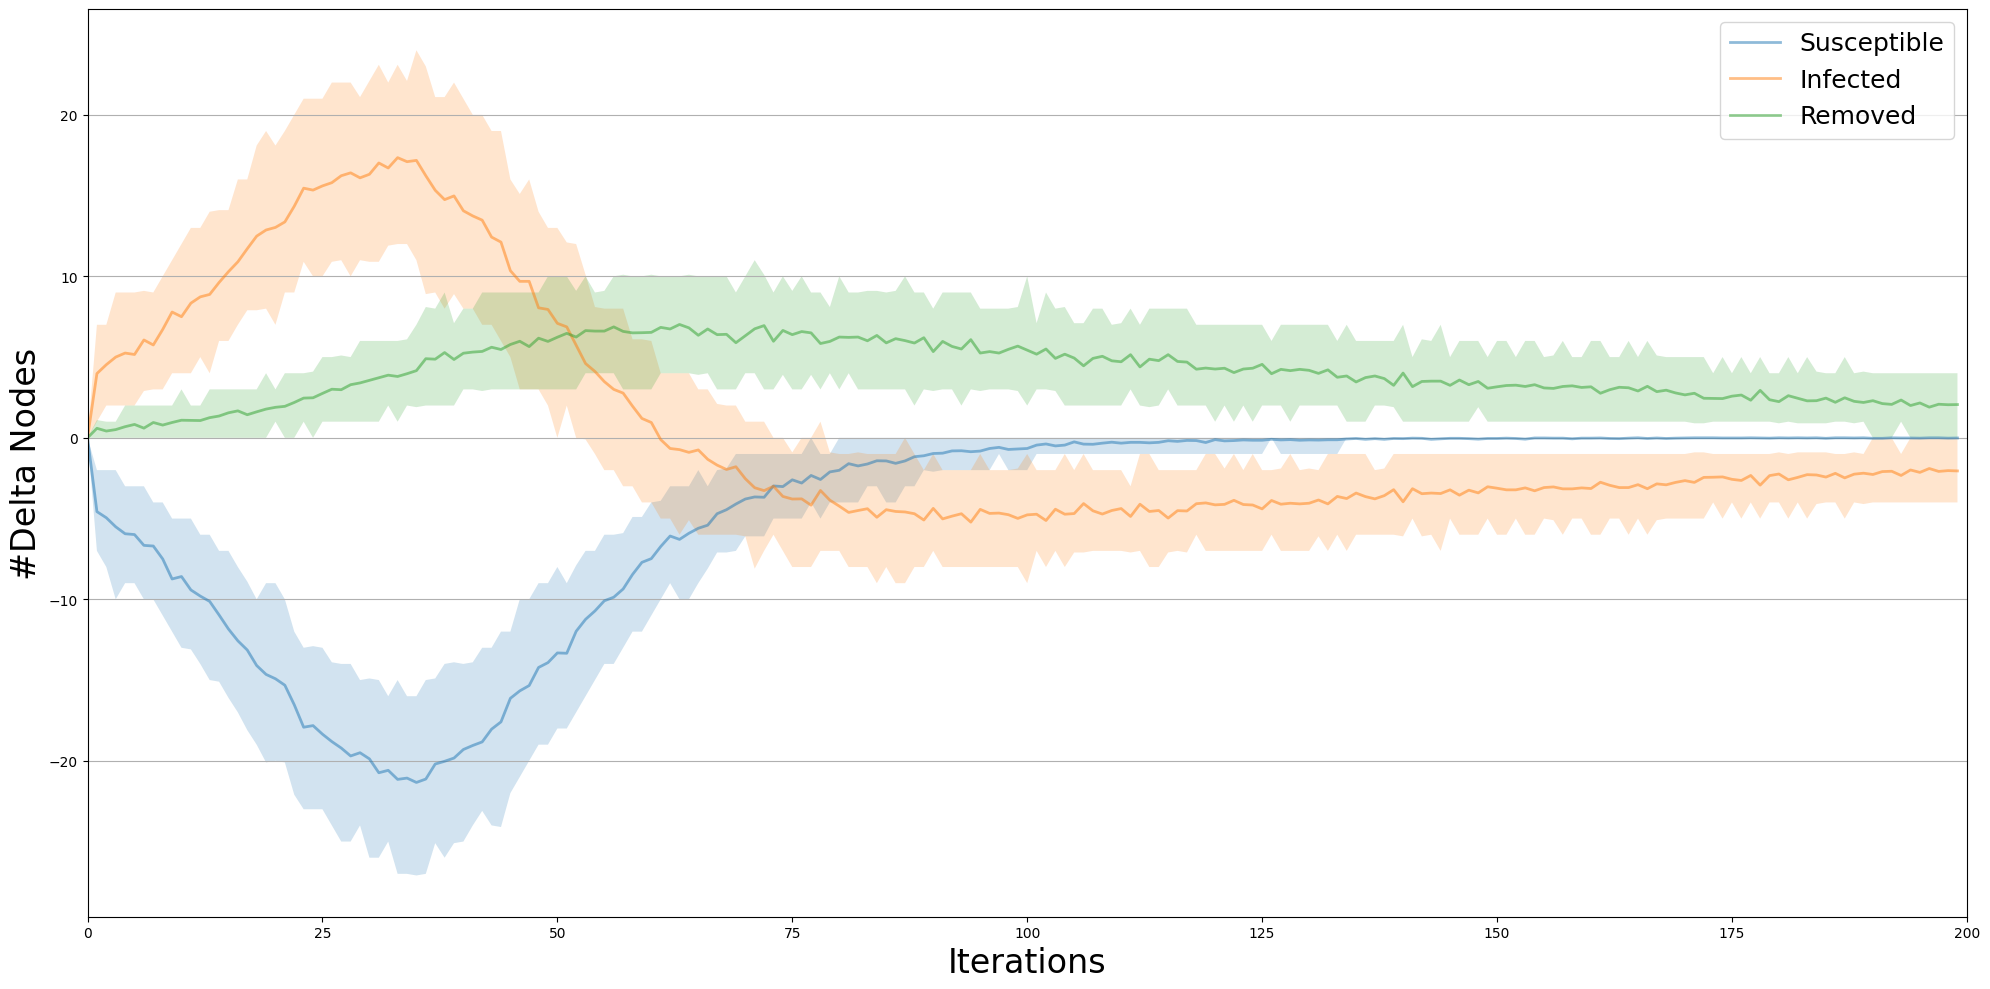

In [127]:
# Plot diffusion prevalence
viz = DiffusionPrevalence(model, trends)
viz.plot()